In [1]:
import os
import sys
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import powerlaw as pl
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

C:\Users\Dylan\AppData\Local\Temp\ipykernel_10176\4176725085.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [11]:
# change matplotlib font to serif
plt.rcParams['font.family'] = ['serif']
# figure size
x_figsize = 10
y_figsize = x_figsize/1.7
# large fontsize
large = 18
# small fontsize
small = 14

In [12]:
# show current databases in data folder
cwd = os.getcwd()
analysis_path = os.path.abspath(os.path.join(cwd, os.pardir))
parent_path = os.path.abspath(os.path.join(analysis_path, os.pardir))
figure_path = f"{cwd}\\figures"

In [13]:
gdp = pd.read_csv('data/GDP.csv')
real_gdp = pd.read_csv('data/GDPC1.csv')
consumption = pd.read_csv('data/PCECC96.csv')
investment = pd.read_csv('data/GPDIC1.csv')
employment = pd.read_csv('data/CE16OV.csv')
unrate = pd.read_csv('data/UNRATE.csv')
cpi = pd.read_csv('data/CPIAUCSL.csv')
wages = pd.read_csv('data/COE.csv')
profits = pd.read_csv('data/A053RC1Q027SBEA.csv')
debt = pd.read_csv('data/TBSDODNS.csv')

In [14]:
macro = pd.DataFrame()
# nominal gross domestic product
macro['ngdp'] = gdp['GDP']
# real gross domestic product
macro['rgdp'] = real_gdp['GDPC1']
# real consumption
macro['consumption'] = consumption['PCECC96']
# real investment
macro['investment'] = investment['GPDIC1']
# total level of employment
macro['employment'] = employment['CE16OV']
# unemployment rate
macro['unrate'] = unrate['UNRATE']/100
# consumer price index
macro['cpi'] = cpi['CPIAUCSL']
# total wages 
macro['wages'] = wages['COE']
# total profits
macro['profits'] = profits['A053RC1Q027SBEA']
# total corporate debt
macro['debt'] = debt['TBSDODNS'] 
# macroframe index
macro.index = gdp['DATE']
# linearly fill missing values
macro = macro.interpolate('linear')
macro

,ngdp,rgdp,consumption,investment,employment,unrate,cpi,wages,profits,debt
DATE,,,,,,,,,,
1950-01-01,280.828,2346.104,1487.854,257.271,57704.666667,0.063,23.640,147.004,33.477,92.0840
1950-04-01,290.383,2417.682,1512.357,284.803,58761.333333,0.054,23.880,153.616,39.923,95.0145
1950-07-01,308.153,2511.127,1590.019,309.285,59457.666667,0.044,24.340,162.303,48.501,97.9450
1950-10-01,319.945,2559.214,1542.087,348.585,59643.000000,0.043,24.980,170.150,53.221,100.8755
1951-01-01,336.000,2593.967,1579.375,312.966,59899.333333,0.034,25.880,178.566,52.393,103.8060
...,...,...,...,...,...,...,...,...,...,...
2018-10-01,20917.867,20304.874,13736.572,3724.752,156643.000000,0.039,252.767,11113.516,2321.840,16766.3140
2019-01-01,21104.133,20415.150,13752.592,3751.760,156683.666667,0.038,254.277,11329.719,2326.006,16846.8340
2019-04-01,21384.775,20584.528,13862.802,3778.211,156892.666667,0.036,255.213,11390.093,2350.614,16846.8340


In [15]:
# define new series
# quarterly data
steps = 4 
# debt ratio
macro['debt_ratio'] = macro['debt']/macro['ngdp']
# wage share of gdp
macro['wage_share'] = macro['wages']/macro['ngdp']
# profit share of gdp
macro['profit_share'] = macro['profits']/macro['ngdp']
# real gdp growth rate
macro['rgdp_growth'] = np.log(macro['rgdp']) - np.log(macro['rgdp'].shift(steps))
# credit 
macro['credit'] = np.log(macro['debt']) - np.log(macro['debt'].shift(steps))
# inflation
macro['inflation'] = np.log(macro['cpi']) - np.log(macro['cpi'].shift(steps))
# wage inflation
macro['wage_inflation'] = np.log(macro['wages']) - np.log(macro['wages'].shift(steps))
# change unemployment
macro['change_unrate'] = macro['unrate'] - macro['unrate'].shift(steps)
# normalised productivity 
macro['productivity'] = (macro['rgdp']/macro['employment'])/(macro['rgdp'].iloc[0]/macro['employment'].iloc[0])
# productivity growth 
macro['productivity_growth'] = np.log(macro['productivity']) - np.log(macro['productivity'].shift(steps))
# drop N/A value
macro = macro.dropna()
macro

,ngdp,rgdp,consumption,investment,employment,unrate,cpi,wages,profits,debt,debt_ratio,wage_share,profit_share,rgdp_growth,credit,inflation,wage_inflation,change_unrate,productivity,productivity_growth
DATE,,,,,,,,,,,,,,,,,,,,
1951-01-01,336.000,2593.967,1579.375,312.966,59899.333333,0.034,25.880,178.566,52.393,103.806,0.308946,0.531446,0.155932,0.100432,0.119823,0.090530,0.194498,-0.029,1.065139,0.063105
1951-04-01,344.090,2638.898,1534.744,320.221,59899.000000,0.032,25.930,184.901,44.593,105.429,0.306399,0.537362,0.129597,0.087552,0.104008,0.082359,0.185365,-0.022,1.083594,0.068376
1951-07-01,351.385,2693.259,1552.624,296.643,59954.333333,0.033,26.030,187.854,40.666,107.712,0.306536,0.534610,0.115731,0.070020,0.095055,0.067129,0.146200,-0.011,1.104896,0.061702
1951-10-01,356.178,2699.156,1561.670,273.007,60114.333333,0.031,26.470,191.495,43.868,110.118,0.309166,0.537638,0.123163,0.053239,0.087665,0.057937,0.118181,-0.012,1.104368,0.045367
1952-01-01,359.820,2727.954,1565.288,280.130,60276.666667,0.029,26.390,196.097,41.590,112.537,0.312759,0.544986,0.115586,0.050364,0.080758,0.019515,0.093651,-0.005,1.113144,0.044084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01,20917.867,20304.874,13736.572,3724.752,156643.000000,0.039,252.767,11113.516,2321.840,16766.314,0.801531,0.531293,0.110998,0.021028,0.048681,0.019826,0.041764,-0.002,3.188255,0.002534
2019-01-01,21104.133,20415.150,13752.592,3751.760,156683.666667,0.038,254.277,11329.719,2326.006,16846.834,0.798272,0.536848,0.110216,0.018344,0.042181,0.018657,0.049455,-0.002,3.204738,0.007187
2019-04-01,21384.775,20584.528,13862.802,3778.211,156892.666667,0.036,255.213,11390.093,2350.614,16846.834,0.787796,0.532626,0.109920,0.021312,0.027235,0.016574,0.044804,-0.004,3.227022,0.012880


In [16]:
years = gdp['DATE']
x_sample = years.iloc[np.arange(0, len(years), 40)].apply(lambda x: x[:4])
x_sample[280] = '2020'
x_sample

0      1950
40     1960
80     1970
120    1980
160    1990
200    2000
240    2010
280    2020
Name: DATE, dtype: object

In [17]:
# functions to be used

# log scale y ticks 
def logscale_ticks(low: float, high: float, num: int) -> np.ndarray:
    """
    Get ticks for either x or y axis from data, rounded to first digit spaced by num in log 10.
    
    Parameters
    ----------
        series : pd.Series
            time series
            
        num : int 
            number of ticks to return
    
    Returns
    -------
        ticks : numpy array
            axis ticks spaced by num in log 10
    """
    log_arr = np.logspace(np.log10(low),np.log10(high), num)
    lengths = np.vectorize(len)(np.char.mod('%d', log_arr))
    factor = 10 ** (lengths - 1)
    round_log_arr = np.int64(np.round(log_arr.astype(int) / factor) * factor)
    return round_log_arr

def plot_autocorrelation(data, figsize: tuple, fontsize: int, savefig: str, lags: int, lamda: int=1600) -> None:
    """
    Plots the autocorrelation function for a given series for a given number of lags.
    
    Parameters
    ----------
        data : series like
            time series
        
        figsize : tuple (int, int) 
            size of figure (x-axis, y-axis)
            
        fontsize : int
            fontsize of legend and ticks
            
        savefig : str
            path and figure name 
        
        lags: int
            number of autocorrelation lags
        
        lamda : int (default = 1600)
            HP lambda parameter (quarterly => lambda=1600)
    """
    # Hodrick-Prescot filter
    cycle, trend = sm.tsa.filters.hpfilter(data, lamda)
    # figure
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)
    # autocorrelation plot
    tsaplots.plot_acf(cycle, lags=lags, ax=ax1, color='k', vlines_kwargs={"colors": 'k'})
    # change shaded colour
    for item in ax1.collections:
        if type(item)==PolyCollection:
            item.set_facecolor('k')
    # ticks
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    # remove title
    plt.title("")
    # save figure
    plt.savefig(savefig, bbox_inches='tight')
    plt.show()

def plot_cross_correlation(x, y, figsize: tuple, fontsize: int, savefig: str, lags: int, lamda: int=1600):
    """
    Plots the cross correlation between series x and series y, from lags to -lags lags.
    
    Parameters
    ----------
        x : series like
            time series
            
        y : series like
            time series
        
        figsize : tuple (int, int) 
            size of figure (x-axis, y-axis)
            
        fontsize : int
            fontsize of legend and ticks
            
        savefig : str
            path and figure name 
        
        lags: int
            number of correlation lags
        
        lamda : int (default = 1600)
            HP lambda parameter (quarterly => lambda=1600)
    """
    # Hodrick-Prescot filter
    xcycle, xtrend = sm.tsa.filters.hpfilter(x, lamda)
    ycycle, ytrend = sm.tsa.filters.hpfilter(y, lamda)
    # figure
    plt.figure(figsize=figsize)
    corr = plt.xcorr(xcycle, ycycle, color='k', maxlags=lags)
    plt.scatter(corr[0], corr[1], color='k')
    plt.axhline(0, color="k")
    # ticks
    plt.xticks([-lags, -lags/2, 0, lags/2, lags], fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    # save figure
    plt.savefig(savefig, bbox_inches='tight')
    plt.show()

# plot complementary cumulative distribution function
def plot_ccdf(data, figsize: tuple, fontsize: int, savefig: str) -> None:
    """
    Plots the complementary cumulative distribution function (CCDF) for a given series 
    and prints the power law exponent, cut-off value, and compares the distribution to a lognormal.
    
    Parameters
    ----------
        data : pd.Series or numpy array
            series to plot CCDF
            
        figsize : tuple (int, int) 
            size of figure (x-axis, y-axis)
            
        fontsize : int
            fontsize of legend and ticks
            
        savefig : str
            path and figure name 
    """
    # power law fit results 
    results = pl.Fit(data)
    a, m = results.alpha, results.xmin
    # complementary cdf 
    plt.figure(figsize=figsize)
    # x values 
    x = np.sort(data)
    # complementary cdf (ccdf)
    cdf = np.arange(1,len(data)+1)/(len(data))
    ccdf = 1 - cdf
    plt.scatter(x, ccdf, color='skyblue', edgecolors='k', alpha=0.7, s=40, label='CCDF')
    # power law fit
    # => rescale to start fit from cut off
    index = np.where(x == m)[0][0]
    rescale = ccdf[index]
    power_law_fit = np.where(x >= m, np.power((m)/x,a-1)*rescale, np.nan)
    plt.plot(x, power_law_fit, color='limegreen', linewidth=3, label='Power-Law Fit')
    # power law cut off (mF)
    plt.axvline(m, color='k', linestyle='--', label=r'$m$'f' = {round(m)}') # type: ignore
    # lognormal distribution
    estimates = stats.lognorm.fit(data)
    cdf = stats.lognorm.cdf(x, estimates[0], estimates[1], estimates[2])
    plt.plot(x, 1 - cdf, color='r', linestyle='-.', linewidth=2, label='Log-Normal Fit')
    # log-log axis
    plt.loglog()
    # legend
    plt.legend(loc='lower left', fontsize=fontsize)
    # tick size
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    # save figure
    plt.savefig(savefig, bbox_inches='tight')
    plt.show()
    print(f'Power law exponent = {a}')
    print(f'Power law minimum = {m}')
    print(f"Distribution compare = {results.distribution_compare('power_law', 'lognormal')}\n")

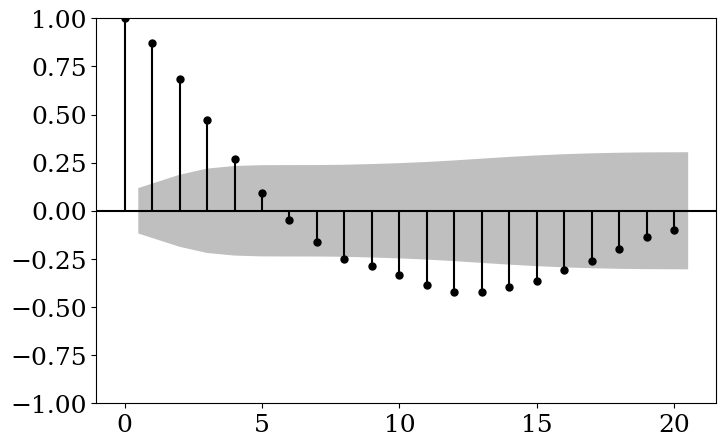

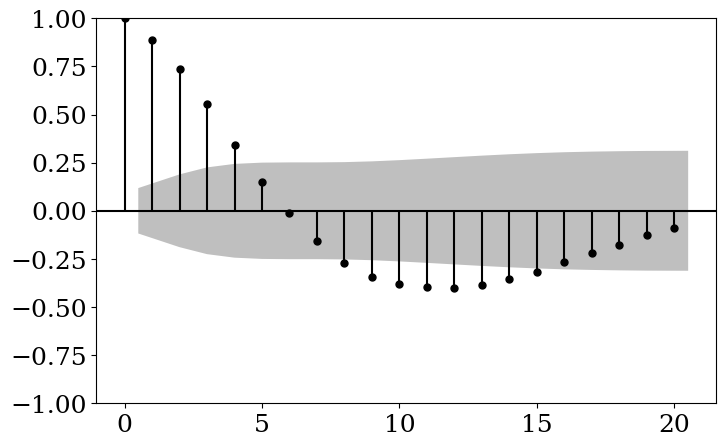

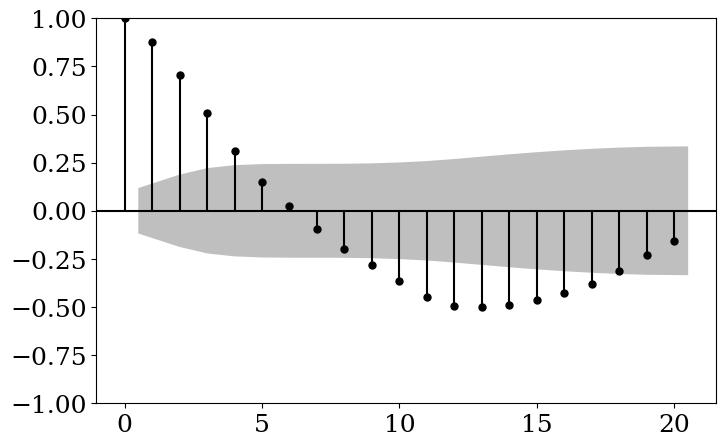

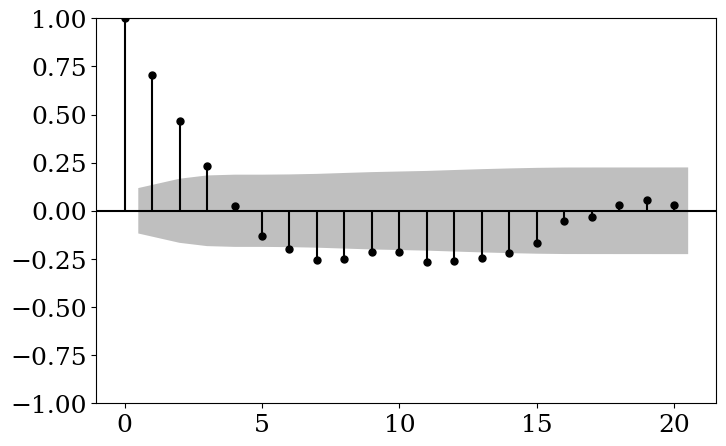

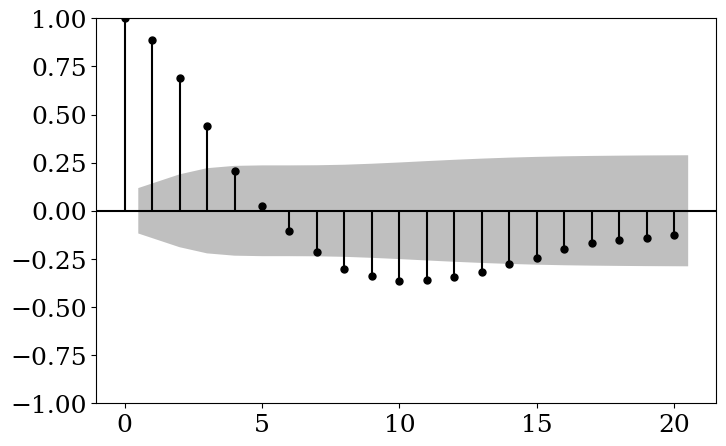

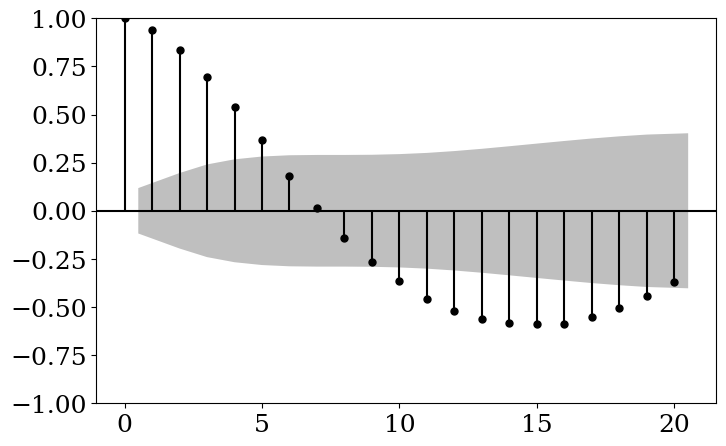

In [28]:
# real gdp autocorrelation
plot_autocorrelation(macro['rgdp'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\autocorr_rgdp.png', lags=20, lamda=1600)
# consumption autocorrelation
plot_autocorrelation(macro['consumption'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\autocorr_consumption.png', lags=20, lamda=1600)
# investment autocorrelation 
plot_autocorrelation(macro['investment'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\autocorr_investment.png', lags=20, lamda=1600)
# productivity autocorrelation
plot_autocorrelation(macro['productivity'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\autocorr_productivity.png', lags=20, lamda=1600)
# unemployment rate autocorrelation
plot_autocorrelation(macro['unrate'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\autocorr_unemployment.png', lags=20, lamda=1600)
# debt autocorrelation
plot_autocorrelation(macro['debt'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\autocorr_debt.png', lags=20, lamda=1600)

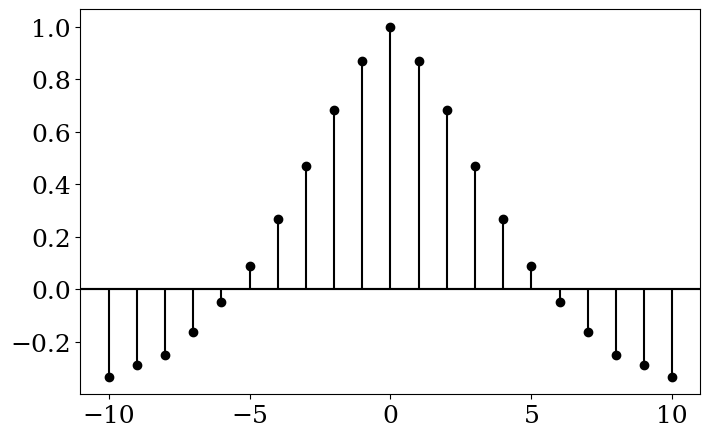

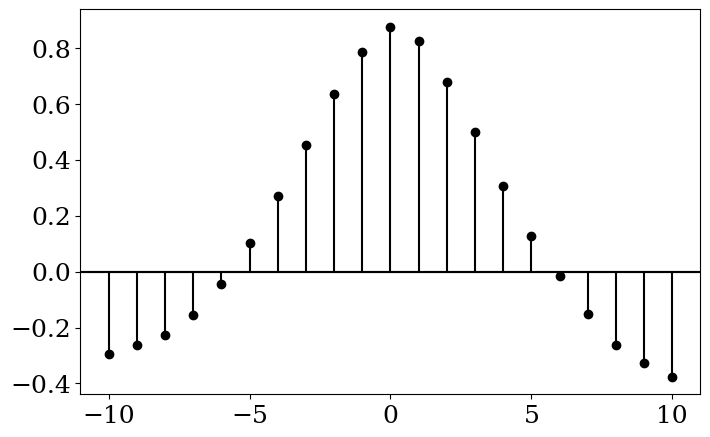

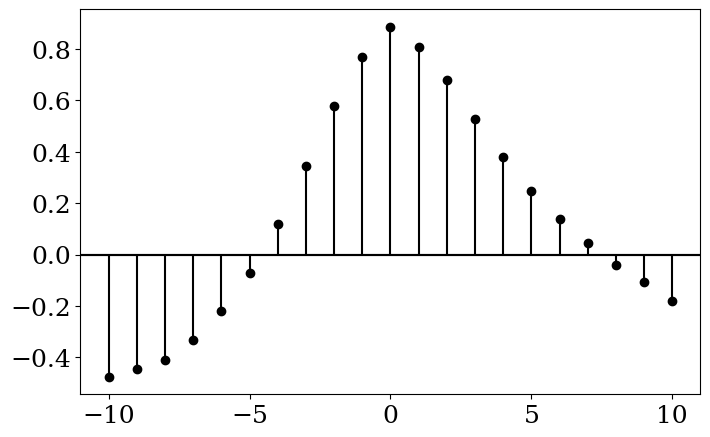

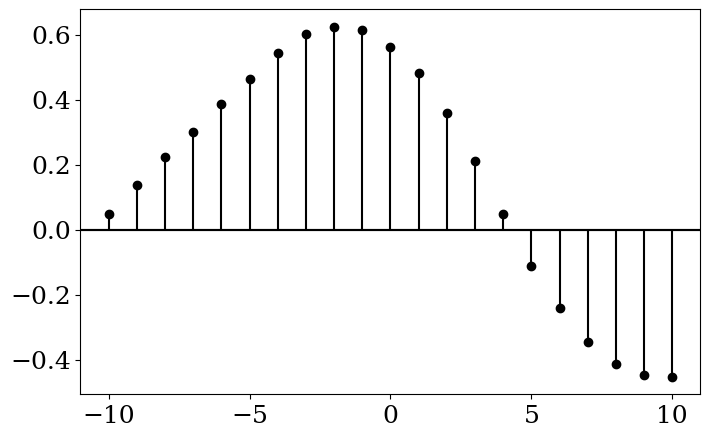

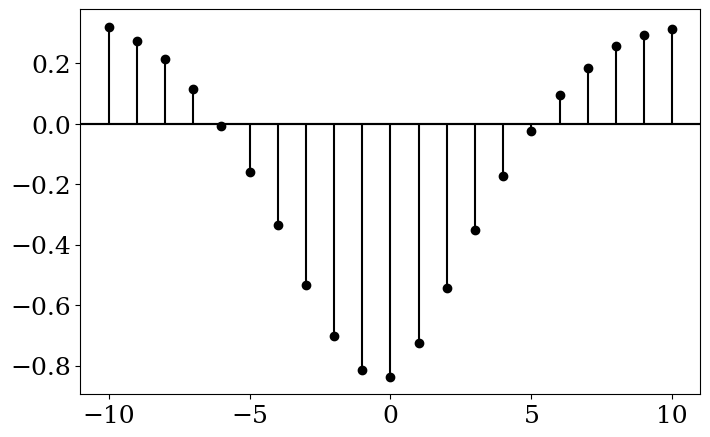

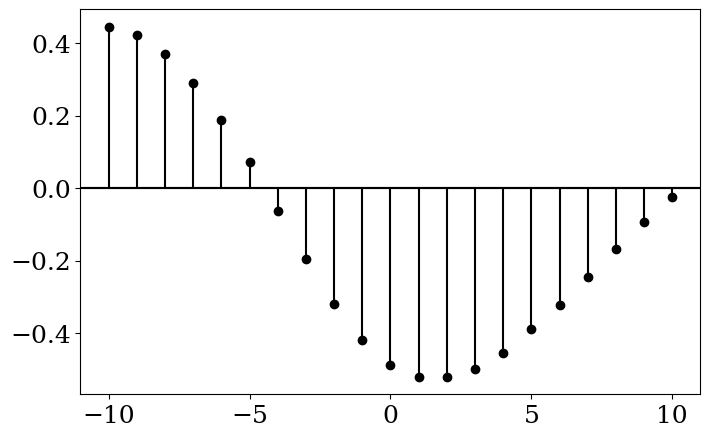

In [27]:
# cross correlation of real gdp with real gdp
plot_cross_correlation(macro['rgdp'], macro['rgdp'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\xcorr_rdgp.png', lags=10, lamda=1600)
# cross correlation of real gdp with consumption
plot_cross_correlation(macro['rgdp'], macro['consumption'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\xcorr_consumption.png', lags=10, lamda=1600)
# cross correlation of real gdp with investment
plot_cross_correlation(macro['rgdp'], macro['investment'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\xcorr_investment.png', lags=10, lamda=1600)
# cross correlation of real gdp with debt
plot_cross_correlation(macro['rgdp'], macro['debt'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\xcorr_debt.png', lags=10, lamda=1600)
# cross correlation of real gdp with unemployment rate
plot_cross_correlation(macro['rgdp'], macro['unrate'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\xcorr_unemployment.png', lags=10, lamda=1600)
# cross correlation of debt with unemployment_rate
plot_cross_correlation(macro['debt'], macro['unrate'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\xcorr_debt_unemployment.png', lags=10, lamda=1600)